In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from IPython.display import display, HTML

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Load data

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
print(f'shape of training data: {train.shape}\nshape of testing data: {test.shape}')

shape of training data: (891, 12)
shape of testing data: (418, 11)


In [3]:
df = pd.concat([train, test], ignore_index=True)

# Data Overview
## missing value
以下欄位有missing value:
* Age
* Cabin (特別多missing value)
* Fare
* Embarked

## data type
* 7 float/int features
* 5 object(string) features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

## Numeric data
* 多數人(>75%)的人沒有和parents, children一起
* 票價分佈範圍很廣，有少數的人買很貴的票
* 有少數年紀很大的人

## Categorical data
* 性別男性占多數
* ticket和cabin有些值重複
* embarked: S港口最多人

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [7]:
df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


## Target: Survived
約有38%的人存活

,counts,%
0.0,549,0.616162
1.0,342,0.383838


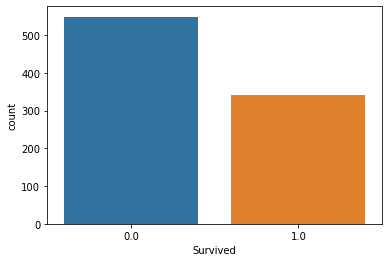

In [8]:
sns.countplot(x='Survived', data=df)
display(pd.concat([df['Survived'].value_counts(), df['Survived'].value_counts(normalize=True)], axis=1, keys=['counts', '%']))

In [9]:
def countplot_percent(feature, data=df):
    '''Plot countplot with percentage of each category.'''
    total = data.shape[0]
    ax = sns.countplot(x=feature, data=data)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x()
        y = p.get_height() + 0.02
        ax.annotate(percentage, (x, y), size = 10)
    plt.show()

# EDA
## Pclass
* 有三種艙等，艙等1最高級，票價最貴，再過來是艙等2、最後是艙等3
* 艙等3的人最多
* 艙等較高，生存率也較高

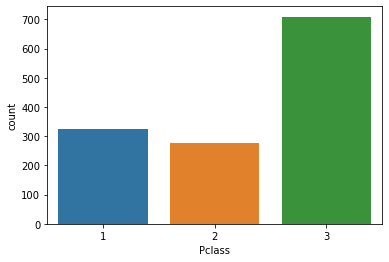

In [10]:
sns.countplot(x='Pclass', data=df)

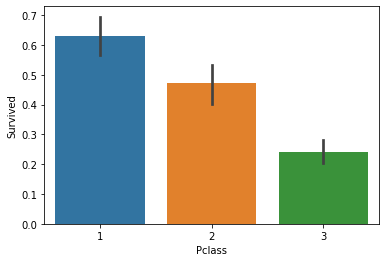

In [11]:
sns.barplot(x='Pclass', y='Survived', data=df)

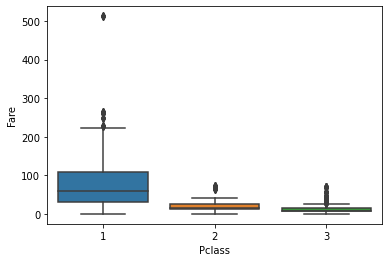

In [12]:
sns.boxplot(x='Pclass', y='Fare', data=df)

## Sex
* 男性約占64%
* 女性的生存率在各個艙等皆高於男性

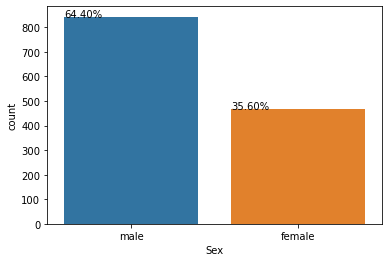

In [13]:
countplot_percent('Sex')

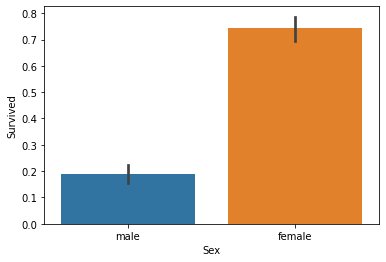

In [14]:
sns.barplot(x='Sex', y='Survived', data=df)

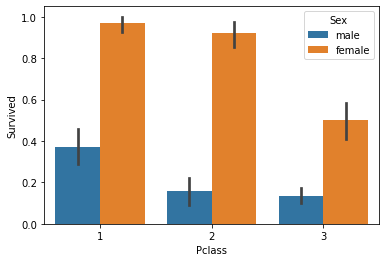

In [15]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)

## Age
由分佈圖可看出，較年輕的乘客(約<15歲)較有可能存活，逃亡時可能禮讓小孩、女性

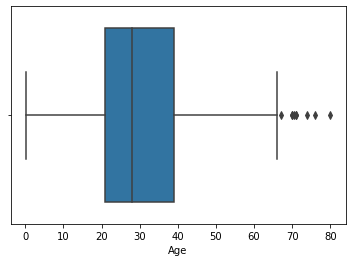

In [16]:
sns.boxplot(df['Age'])

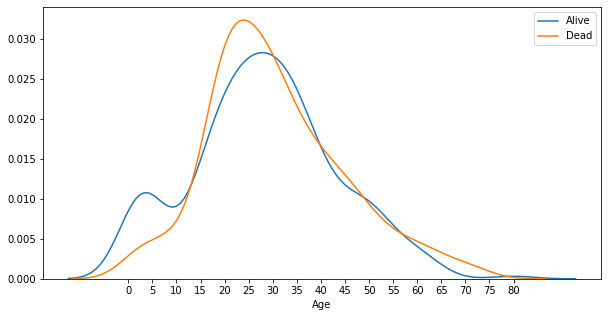

In [17]:
# Age distribution of pepple who survived/did not survive
plt.figure(figsize=(10,5))
sns.distplot(df.loc[(df['Age'].notnull()) & (df['Survived']==1), 'Age'], hist=False, label='Alive').set_xticks(range(0,85,5))
sns.distplot(df.loc[(df['Age'].notnull()) & (df['Survived']==0), 'Age'], hist=False, label='Dead').set_xticks(range(0,85,5))
plt.show()

## SibSp & Parch
* SibSp=兄弟姊妹+配偶數量；Parch=父母+小孩數量
* 大部分的人沒有跟兄弟姊妹/配偶來；大部分的人沒有跟父母/小孩來
* 跟多個(>=3)個兄弟姊妹/配偶來的人生存率較低，沒有跟兄弟姊妹/配偶來的人以及跟1~2位兄弟姊妹/配偶來的人較有可能生存
* 跟多個(>=4)個父母/小孩來的人生存率較低，沒有跟父母/小孩來的人以及跟1~3位父母/小孩來的人較有可能生存

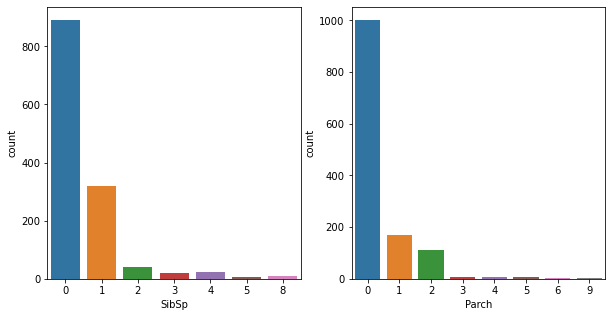

In [18]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(df['SibSp'], ax=axes[0])
sns.countplot(df['Parch'], ax=axes[1])

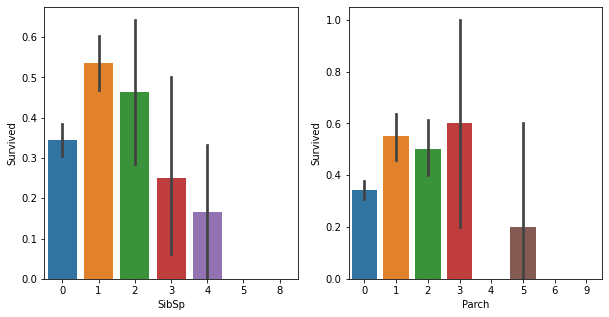

In [19]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x='SibSp', y='Survived', data=df, ax=axes[0])
sns.barplot(x='Parch', y='Survived', data=df, ax=axes[1])

## Fare
* 有少數票價特別高
* 票價較低的乘客，生存率較低，同Pclass

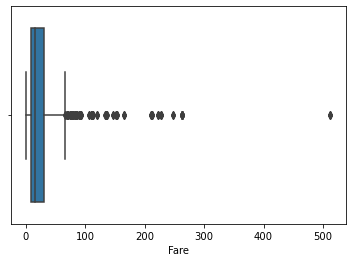

In [20]:
# 票價分佈很廣且傾斜，有很低的也有很高的
sns.boxplot(df['Fare'])

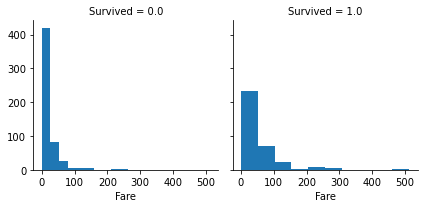

In [21]:
g = sns.FacetGrid(df, col='Survived')
g.map(plt.hist, 'Fare')

## Embarked
* 約72%的人在S港口登船
* C港口生存率較高，可能跟C港口登船的人買的票價較高有關

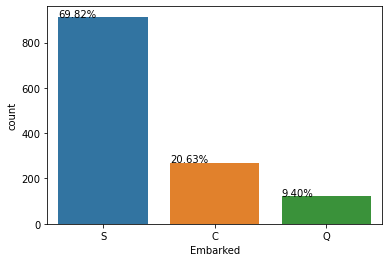

In [22]:
countplot_percent('Embarked')

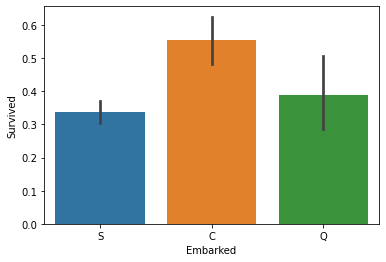

In [23]:
sns.barplot(x='Embarked', y='Survived', data=df)

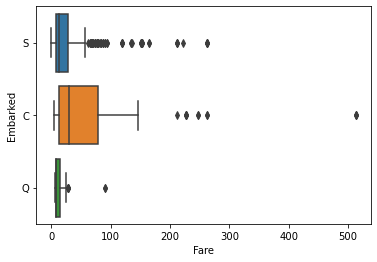

In [24]:
sns.boxplot(x='Fare', y='Embarked', data=train)

## Feature engineering
### Title
從Name中可以發現有稱謂(Mr., Mrs., Master, Miss, etc.)，將稱謂萃取出來
* Title: extract title from name
* Mrs, Miss, Master生存率較高，Master平均年齡為5歲，推斷逃難時禮讓婦女小孩
* 除了Mr, Mrs, Miss, Master，其他Title數量非常少，將其依性別與其他類別合併

In [25]:
df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [26]:
df['Title'] = df['Name'].str.split(', ')
df['Title'] = df['Title'].map(lambda x: str(x[1]).split('.')[0])
df['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

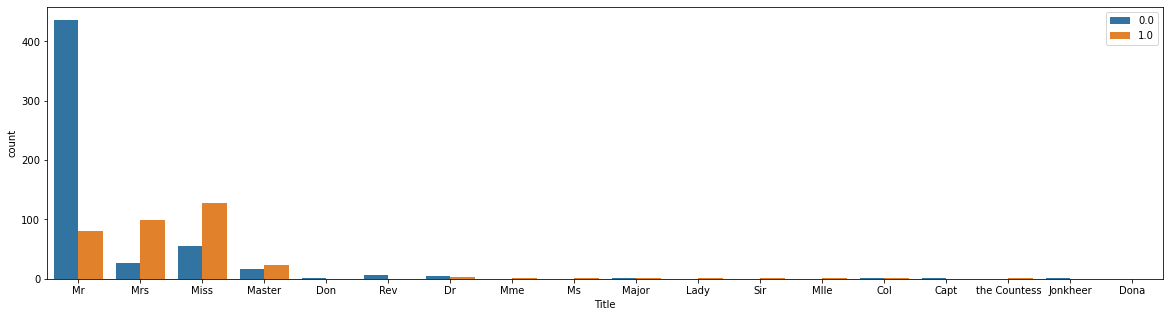

In [27]:
plt.figure(figsize=(20, 5))
sns.countplot(x='Title', hue='Survived', data=df)
plt.legend(loc='upper right')
plt.show()

In [28]:
df.groupby('Title')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Capt,1.0,70.000000,NaN,70.00,70.00,70.0,70.00,70.0
Col,4.0,54.000000,5.477226,47.00,51.50,54.5,57.00,60.0
Don,1.0,40.000000,NaN,40.00,40.00,40.0,40.00,40.0
Dona,1.0,39.000000,NaN,39.00,39.00,39.0,39.00,39.0
Dr,7.0,43.571429,11.731115,23.00,38.00,49.0,51.50,54.0
Jonkheer,1.0,38.000000,NaN,38.00,38.00,38.0,38.00,38.0
Lady,1.0,48.000000,NaN,48.00,48.00,48.0,48.00,48.0
Major,2.0,48.500000,4.949747,45.00,46.75,48.5,50.25,52.0
Master,53.0,5.482642,4.161554,0.33,2.00,4.0,9.00,14.5


In [29]:
pd.crosstab(df['Sex'], df['Title'], margins=True)

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess,All
Sex,,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1,466
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0,843
All,1,4,1,1,8,1,1,2,61,260,2,1,757,197,2,8,1,1,1309


In [30]:
df['Title'] = df['Title'].replace(['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Ms', 'Rev','Sir', 'the Countess'], 
                                  ['Mr', 'Mr', 'Mr', 'Mrs', 'Mr', 'Mr', 'Mrs', 'Mr', 'Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs'])

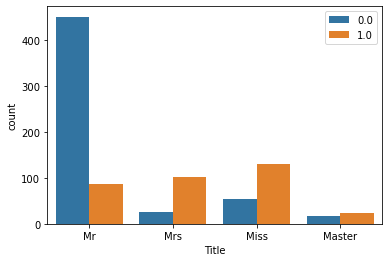

In [31]:
sns.countplot(x='Title', hue='Survived', data=df)
plt.legend(loc='upper right')
plt.show()

### FamilySize
* 新增特徵: FamilySize = SibSp + Parch + 1
* FamilySize 1~4的生存率有逐漸上升的跡象，但>4之後的生存率反而降低

In [32]:
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
df[['Parch', 'SibSp', 'FamilySize']].head()

,Parch,SibSp,FamilySize
0,0,1,2
1,0,1,2
2,0,0,1
3,0,1,2
4,0,0,1


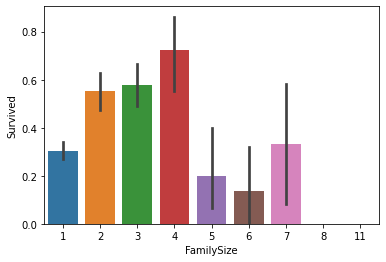

In [33]:
sns.barplot(x='FamilySize', y='Survived', data=df)

# Preprocessing

## Convert Sex to int
male: 0；female: 1

In [34]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

## Impute missing value
* Embarked: 以mode取代
* Fare: 為right skewed distribution，以Pclass=3的median取代

In [35]:
# Replace missing value in Embarked with mode
embarked_mode = train['Embarked'].mode()[0]
df['Embarked'].fillna(embarked_mode, inplace = True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,Mr,1


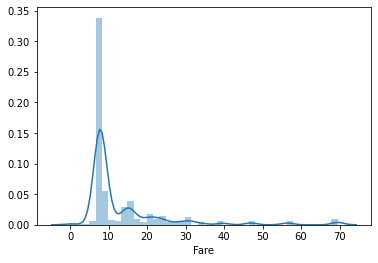

In [36]:
# Only 1 passenger's fare is missing, whose Pclass is 3.
# Fare of Pclass=3 is right skewed, replace NAN with median.
display(df.loc[df['Fare'].isnull()])
sns.distplot(df.loc[df['Pclass']==3, 'Fare'])
plt.show()

fare_median = df.loc[df['Pclass']==3, 'Fare'].median()
df['Fare'].fillna(fare_median, inplace = True)

## Ticket & Cabin
新增欄位: Cabin_fill: 填補Cabin的missing value後的欄位
* 有乘客共用Ticket，相同Ticket的Cabin第一個字母也幾乎相同
* 取Cabin的第一個英文字母
* 77%的Cabin為missing value。以相同Ticket的Cabin眾數填補，其餘的NAN，則以'NoCabin'填補
* Cabin missing data太多，考慮刪掉

In [37]:
df['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [38]:
df['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [39]:
# Info of passengers with shared tickets
shared_ticket = df['Ticket'].value_counts().where(lambda x: x>1).dropna().index
df.loc[df['Ticket'].isin(shared_ticket), 
          ['Ticket', 'Cabin', 'Name', 'Survived', 'FamilySize', 'Pclass']].sort_values(by='Ticket').head(30)

,Ticket,Cabin,Name,Survived,FamilySize,Pclass
257,110152,B77,"Cherry, Miss. Gladys",1.0,1,1
504,110152,B79,"Maioni, Miss. Roberta",1.0,1,1
759,110152,B77,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1.0,1,1
558,110413,E67,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1.0,3,1
262,110413,E67,"Taussig, Mr. Emil",0.0,3,1
585,110413,E68,"Taussig, Miss. Ruth",1.0,3,1
475,110465,A14,"Clifford, Mr. George Quincy",0.0,1,1
110,110465,C110,"Porter, Mr. Walter Chamberlain",0.0,1,1
366,110813,D37,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",1.0,2,1
1127,110813,D37,"Warren, Mr. Frank Manley",NaN,2,1


In [40]:
# 取Cabin的第一個字母
df['Cabin_letter'] = df['Cabin'].map(lambda x: str(x)[0] if pd.notna(x) else np.nan)
cabin = df.loc[df['Ticket'].isin(shared_ticket)].groupby('Ticket')['Cabin_letter'].agg(lambda x: np.nan if x.isnull().all() else x.mode()[0])
cabin.head(10)

Ticket
110152      B
110413      E
110465      A
110813      D
111361      B
112058      B
112378    NaN
113059    NaN
113503      C
113505      E
Name: Cabin_letter, dtype: object

In [41]:
# 以各ticket group的Cabin眾數取代NAN，最後將剩下的NAN以'NoCabin'取代
df['Cabin_fill'] = df['Cabin_letter'].fillna(df['Ticket'].map(cabin.to_dict()))
df['Cabin_fill'] = df['Cabin_fill'].fillna('NoCabin')

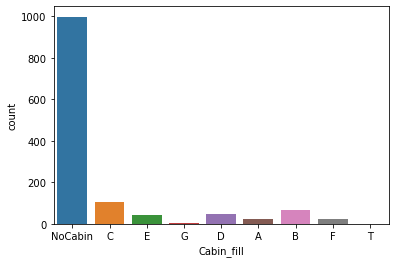

In [42]:
sns.countplot('Cabin_fill', data=df)

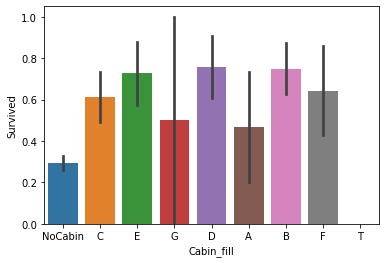

In [43]:
sns.barplot(x='Cabin_fill', y='Survived', data=df)

新增欄位: Ticket_Survived  
觀察共用Ticket的乘客資訊，可發現有全數生還的(如Ticket 110152,111361)；有全數死亡的(如110465)；也有部分生還部分死亡的(如110413)。將Ticket_Survived預設為0.5，觀察同一個Ticket group，若group size > 1:
* 若除了自己有人存活，則Ticket_Survived = 1
* 若除了自己皆無生存資訊(資料皆在test data)，則Ticket_Survived = 0.5
* 若除了自己無人存活，則Ticket_Survived = 0

In [44]:
df.loc[df['Ticket'].isin(shared_ticket), 
          ['Ticket', 'Survived', 'Name', 'FamilySize', 'Pclass']].sort_values(by='Ticket').head(30)

,Ticket,Survived,Name,FamilySize,Pclass
257,110152,1.0,"Cherry, Miss. Gladys",1,1
504,110152,1.0,"Maioni, Miss. Roberta",1,1
759,110152,1.0,"Rothes, the Countess. of (Lucy Noel Martha Dye...",1,1
558,110413,1.0,"Taussig, Mrs. Emil (Tillie Mandelbaum)",3,1
262,110413,0.0,"Taussig, Mr. Emil",3,1
585,110413,1.0,"Taussig, Miss. Ruth",3,1
475,110465,0.0,"Clifford, Mr. George Quincy",1,1
110,110465,0.0,"Porter, Mr. Walter Chamberlain",1,1
366,110813,1.0,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",2,1
1127,110813,NaN,"Warren, Mr. Frank Manley",2,1


In [45]:
df['Ticket_survived'] = 0.5
for name, group in df.groupby('Ticket'):
    if (len(group) > 1):
        for ind, row in group.iterrows():
            if 1 in group.drop(ind)['Survived'].values:
                df.loc[df['PassengerId'] == row['PassengerId'], 'Ticket_survived'] = 1
            elif 0 in group.drop(ind)['Survived'].values:
                df.loc[df['PassengerId'] == row['PassengerId'], 'Ticket_survived'] = 0

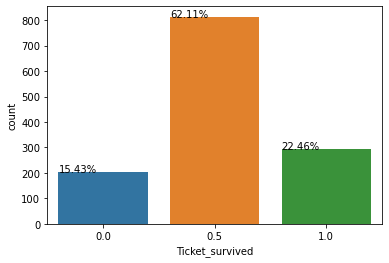

In [46]:
countplot_percent('Ticket_survived')

## Impute missing value: Age
* 年齡上，Pclass=1 > Pclass=2 > Pclass=3
* 以Title來說，Mr與Mrs年齡中位數差不多，且大於Miss，Miss的年齡大於Master
* 依Title與Pclass的中位數填補Age的missing value
* 從violin plot可看出較年輕的乘客生存率較高

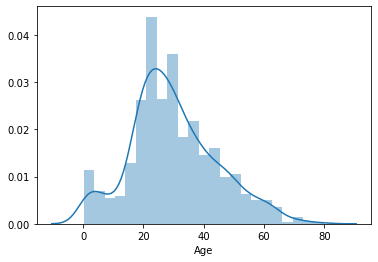

In [47]:
sns.distplot(df['Age'])

Text(0.5, 1.0, 'Age vs Title vs Pclass')

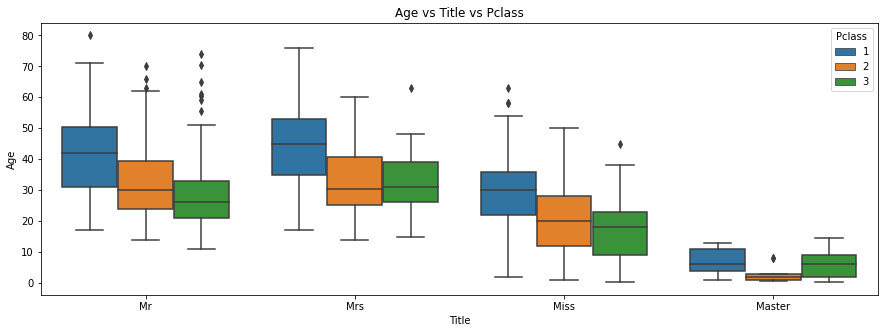

In [48]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='Title', y='Age', hue='Pclass', data=df)
plt.title('Age vs Title vs Pclass')

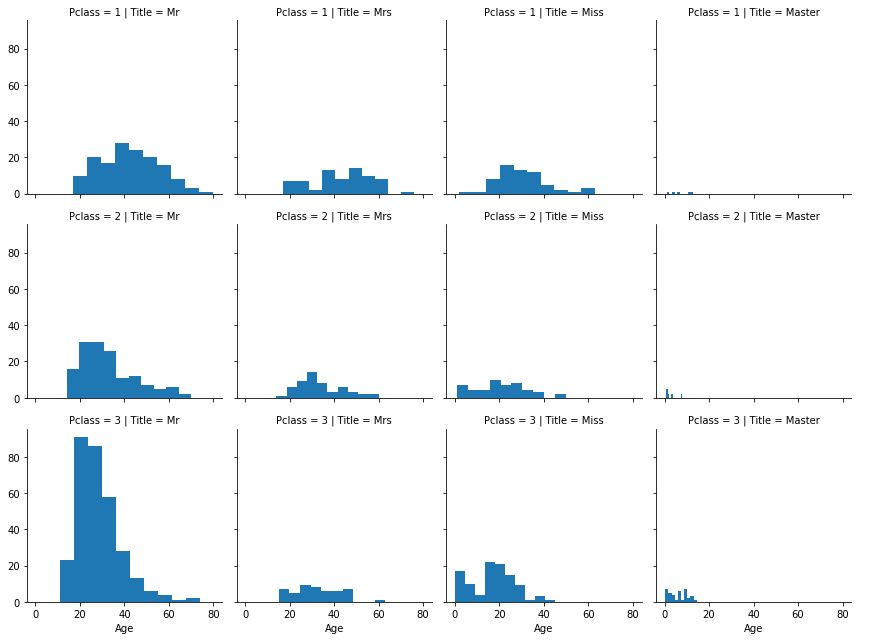

In [49]:
g = sns.FacetGrid(df, row='Pclass', col='Title')
g.map(plt.hist, 'Age')
g.add_legend();

In [50]:
# Median of age
df.groupby(['Title', 'Pclass'])['Age'].median()

Title   Pclass
Master  1          6.0
        2          2.0
        3          6.0
Miss    1         30.0
        2         20.0
        3         18.0
Mr      1         42.0
        2         30.0
        3         26.0
Mrs     1         45.0
        2         30.5
        3         31.0
Name: Age, dtype: float64

In [51]:
df['Age_fill'] = df['Age']
for title in df['Title'].unique():
    for pclass in df['Pclass'].unique():
        age_median = df.loc[(df['Title']==title) & (df['Pclass']==pclass), 'Age'].median()
        if np.isnan(age_median):
            age_median = round(df.loc[df['Title']==title, 'Age'].median())
        else:
            age_median = round(age_median)
        df.loc[(df['Age'].isnull()) & (df['Title']==title) & (df['Pclass']==pclass), 'Age_fill'] = age_median

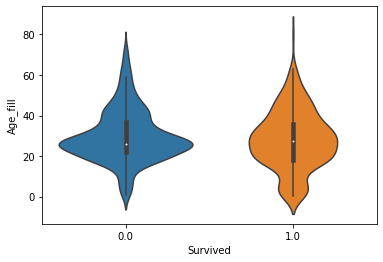

In [52]:
sns.violinplot(x='Survived', y='Age_fill', data=df)

## Discrete Age, Fare
* 將Fare分別分成4~6組，之後再比較performance決定採取幾個bins
* 將年齡分為>15與<15
* 將年齡分成5組

In [53]:
df['Fare_4bins'] = pd.qcut(df['Fare'], 4)
df['Fare_5bins'] = pd.qcut(df['Fare'], 5)
df['Fare_6bins'] = pd.qcut(df['Fare'], 6)

分割後，fare越高，生存率越高

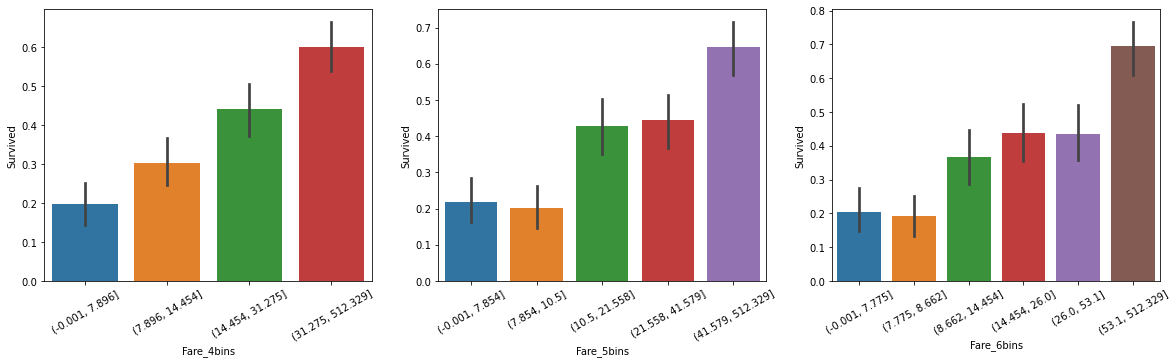

In [54]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Fare_4bins', y='Survived', data=df)
plt.xticks(rotation=30)
plt.subplot(1, 3, 2)
sns.barplot(x='Fare_5bins', y='Survived', data=df)
plt.xticks(rotation=30)
plt.subplot(1, 3, 3)
sns.barplot(x='Fare_6bins', y='Survived', data=df)
plt.xticks(rotation=30)
plt.show()

In [55]:
le = LabelEncoder()
for col in ['Fare_4bins', 'Fare_5bins', 'Fare_6bins']:
    df[col] = le.fit_transform(df[col])

* 由下圖前段可觀察出，年齡<15歲生存率較年齡>15歲高
* 新增欄位: Age<15。將年齡分成<15與>15

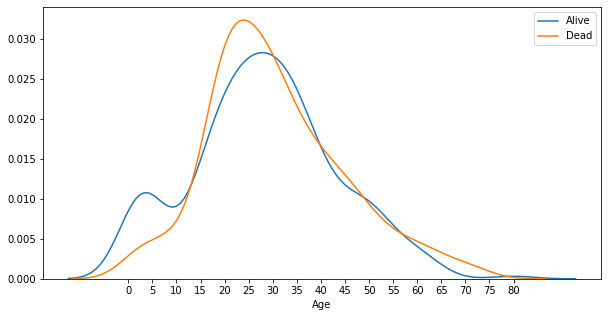

In [56]:
plt.figure(figsize=(10,5))
sns.distplot(df.loc[df['Survived']==1, 'Age'], hist=False, label='Alive').set_xticks(range(0,85,5))
sns.distplot(df.loc[df['Survived']==0, 'Age'], hist=False, label='Dead').set_xticks(range(0,85,5))
plt.show()

In [57]:
df['Age<15'] = (df['Age_fill'] < 15).astype(int)

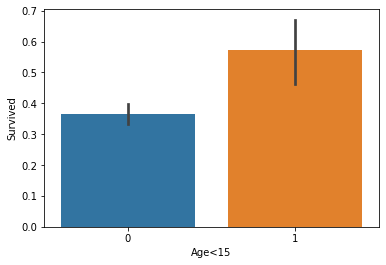

In [58]:
sns.barplot(x='Age<15', y='Survived', data=df)

In [59]:
df['Age_bin'] = pd.qcut(df['Age_fill'], 5)

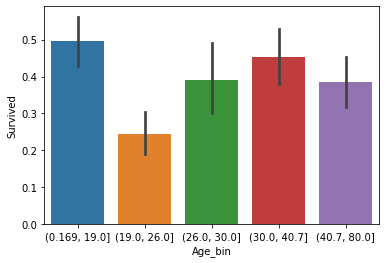

In [60]:
sns.barplot(x='Age_bin', y='Survived', data=df)

In [61]:
df['Age_bin'] = le.fit_transform(df['Age_bin'])

## Label encoding
將欄位Cabin, Embarked, Title做label encoding

In [62]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize',
       'Cabin_letter', 'Cabin_fill', 'Ticket_survived', 'Age_fill',
       'Fare_4bins', 'Fare_5bins', 'Fare_6bins', 'Age<15', 'Age_bin'],
      dtype='object')

In [63]:
df.drop(['SibSp', 'Parch', 'Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Cabin_letter', 'Age_fill'],axis=1, inplace=True)

In [64]:
le_col = ['Cabin_fill', 'Embarked', 'Title']
for col in le_col:
    df[col] = le.fit_transform(df[col])

In [65]:
df.isnull().sum()

PassengerId          0
Survived           418
Pclass               0
Sex                  0
Embarked             0
Title                0
FamilySize           0
Cabin_fill           0
Ticket_survived      0
Fare_4bins           0
Fare_5bins           0
Fare_6bins           0
Age<15               0
Age_bin              0
dtype: int64

# Modeling

In [66]:
df_train = df[:train.shape[0]]
df_test = df[train.shape[0]:]
df_test.drop(['Survived'], axis=1, inplace=True)
df_train['Survived'] = df_train['Survived'].astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [67]:
# Train random forest model with given features, and return cross validation score
def rf_train(col):
    rf = RandomForestClassifier(n_estimators=100, random_state=1)
    scores = cross_val_score(rf, df_train[col], df_train['Survived'], cv=5, scoring='accuracy')
    print(scores.mean())

In [68]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Embarked', 'Title',
       'FamilySize', 'Cabin_fill', 'Ticket_survived', 'Fare_4bins',
       'Fare_5bins', 'Fare_6bins', 'Age<15', 'Age_bin'],
      dtype='object')

In [69]:
# Fare_4bins表現較好
col = ['Pclass', 'Sex', 'Embarked', 'Title', 'FamilySize', 'Ticket_survived', 'Fare_4bins', 'Age<15', 'Age_bin']
rf_train(col)
col = ['Pclass', 'Sex', 'Embarked', 'Title', 'FamilySize', 'Ticket_survived', 'Fare_5bins', 'Age<15', 'Age_bin']
rf_train(col)
col = ['Pclass', 'Sex', 'Embarked', 'Title', 'FamilySize', 'Ticket_survived', 'Fare_6bins', 'Age<15', 'Age_bin']
rf_train(col)

0.8462682819659783
0.8462431736865232
0.840631473228297


## Hyperparameter tunning

In [70]:
%%time
col = ['Pclass', 'Sex', 'Embarked', 'Title', 'FamilySize', 'Ticket_survived', 'Fare_4bins', 'Age<15', 'Age_bin']
rf = RandomForestClassifier(random_state=1)
param = {'n_estimators': np.arange(50, 501, 50),
         'max_depth': np.arange(5, 21, 5),
         'min_samples_split': np.arange(5, 26, 5),
         'min_samples_leaf': np.arange(2, 11, 2),
         'max_leaf_nodes':  np.arange(10, 41, 10)
        }

grid = GridSearchCV(estimator=rf, param_grid=param, cv=5, verbose=0, scoring='accuracy', n_jobs = -1, return_train_score=True)
# grid.fit(df_train[col], df_train['Survived'])

# print(grid.best_params_)
# print(grid.best_score_)
# print(grid.best_estimator_)

CPU times: user 152 µs, sys: 0 ns, total: 152 µs
Wall time: 117 µs


## Predict

In [71]:
# Before tuning, score = 0.76315
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(df_train[col], df_train['Survived'])
result = rf.predict(df_test[col])
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': result})
output.to_csv('before_tuning.csv', index = False)

In [72]:
# After tuning, score = 0.80143
rf_params = {'max_depth': 15, 'max_leaf_nodes': 40, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
rf = RandomForestClassifier(**rf_params)

rf.fit(df_train[col], df_train['Survived'])
result = rf.predict(df_test[col])
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': result})
output.to_csv('after_tuning.csv', index = False)